## Running this notebook

You can launch this notebook using mybinder by clicking the button below.

<a href="https://mybinder.org/v2/gh/US-GHG-Center/ghgc-docs/HEAD?labpath=user_data_notebooks/nasa_ceos_co2_flux.ipynb">
<img src="https://mybinder.org/badge_logo.svg" alt="Binder" title="A cute binder" width="150"/> 
</a>

## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the Air-Sea CO2 Flux, ECCO-Darwin Model v5 Data product.
2. Pass the STAC item into the raster API `/stac/tilejson.json `endpoint.
3. Using `folium.plugins.DualMap`, we will visualize two tiles (side-by-side), allowing us to compare time points. 
4. After the visualization, we will perform zonal statistics for a given polygon.

   

## About the Data

The ocean is a major sink for atmospheric carbon dioxide (CO2), largely due to the presence of phytoplankton that use the CO2 to grow. Studies have shown that global ocean CO2 uptake has increased over recent decades however there is uncertainty in the various mechanisms that affect ocean CO2 flux and storage and how the ocean carbon sink will respond to future climate change. Because CO2 fluxes can vary significantly across space and time, combined with deficiencies in ocean and atmosphere CO2 observations, there is a need for models that can thoroughly represent these processes. Ocean biogeochemical models (OBMs) have the ability to resolve the physical and biogeochemical mechanisms contributing to spatial and temporal variations in air-sea CO2 fluxes but previous OBMs do not integrate observations to improve model accuracy and have not be able to operate on the seasonal and multi-decadal timescales needed to adequately characterize these processes. The ECCO-Darwin model is an OBM that assimilates Estimating the Circulation and Climate of the Ocean (ECCO) consortium ocean circulation estimates and biogeochemical processes from the Massachusetts Institute of Technology (MIT) Darwin Project. A pilot study using ECCO-Darwin was completed by [Brix et al. (2015)](https://doi.org/10.1016/j.ocemod.2015.07.008) however an improved version of the model was developed by [Carroll et al. (2020)](https://doi.org/10.1029/2019MS001888) in which issues present in the first model were addressed using data assimilation and adjustments were made to initial conditions and biogeochemical parameters. The updated ECCO-Darwin model was compared with interpolation-based products to estimate surface ocean partial pressure (pCO2) and air-sea CO2 flux. This dataset contains the gridded global, monthly mean air-sea CO2 fluxes from version 5 of the ECCO-Darwin model. The data are available at ~1/3° horizontal resolution at the equator (~18 km at high latitudes) from January 2020 through December 2022.

## Querying the STAC API

In [4]:
import requests
from folium import Map, TileLayer
from pystac_client import Client

In [5]:
# Provide STAC and RASTER API endpoints
STAC_API_URL = "http://dev.ghg.center/api/stac"
RASTER_API_URL = "https://dev.ghg.center/api/raster"

# Please use the collection name similar to the one used in STAC collection.
# Name of the collection for Ecco Darwin CO2 flux dataset. 
collection_name = "eccodarwin-co2flux-monthgrid-v5"

In [6]:
# Fetching the collection from STAC collections using appropriate endpoint.
collection = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()
collection

{'id': 'tm54dvar-ch4flux-monthgrid-v1',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/tm54dvar-ch4flux-monthgrid-v1/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/tm54dvar-ch4flux-monthgrid-v1'}],
 'title': 'TM5-4DVar Isotopic CH4 Inverse Fluxes',
 'assets': None,
 'extent': {'spatial': {'bbox': [[-180.0, -90.0, 180.0, 90.0]]},
  'temporal': {'interval': [['1999-01-01 00:00:00+00',
     '2016-12-31 00:00:00+00']]}},
 'license': 'CC-BY-4.0',
 'keywords': None,
 'providers': None,
 'description': 'Global, mont

Examining the contents of our `collection` under the `temporal` variable, we see that the data is available from January 1999 to December 2016. By looking at the `dashboard:time density`, we observe that the data is periodic with monthly time density.

In [7]:
# Check total number of items available
items = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit=500").json()["features"]
print(f"Found {len(items)} items")

Found 216 items


In [8]:
# Examining the first item in the collection
items[0]

{'id': 'tm54dvar-ch4flux-monthgrid-v1-201612',
 'bbox': [-180.0, -90.0, 180.0, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/tm54dvar-ch4flux-monthgrid-v1'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/tm54dvar-ch4flux-monthgrid-v1'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/tm54dvar-ch4flux-monthgrid-v1/items/tm54dvar-ch4flux-monthgrid-v1-201612'}],
 'assets': {'total': {'href': 's3://ghgc-data-store-dev/tm5-ch4-inverse-flux/methane_emis_total_201612.tif',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
   'roles'

Below, we are entering the minimum and maximum values to provide our upper and lower bounds in `rescale_values`.

## Exploring Changes in CO₂ Levels Using the Raster API

In this notebook, we will explore the global changes of CO2 budgets over time in urban regions. We will visualize the outputs on a map using `folium.`

In [10]:
# to access the year value from each item more easily, this will let us query more explicity by year and month (e.g., 2020-02)
items = {item["properties"]["start_datetime"]: item for item in items} 
asset_name = "fossil" #fossil fuel

In [11]:
# Fetching the min and max values for a specific item
rescale_values = {"max":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["max"], "min":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["min"]}

Now, we will pass the item id, collection name, and `rescaling_factor` to the `Raster API` endpoint. We will do this twice, once for 2020 and again for 2019, so that we can visualize each event independently.

In [12]:
color_map = "magma"
oco2_flux_1 = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[list(items.keys())[0]]['collection']}&item={items[list(items.keys())[0]]['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
oco2_flux_1

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://2qncpyg24c.execute-api.us-west-2.amazonaws.com/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=tm54dvar-ch4flux-monthgrid-v1&item=tm54dvar-ch4flux-monthgrid-v1-201612&assets=fossil&color_formula=gamma+r+1.05&colormap_name=magma&rescale=0.0%2C202.8189294183266'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [13]:
oco2_flux_2 = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[list(items.keys())[1]]['collection']}&item={items[list(items.keys())[1]]['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
oco2_flux_2

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://2qncpyg24c.execute-api.us-west-2.amazonaws.com/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=tm54dvar-ch4flux-monthgrid-v1&item=tm54dvar-ch4flux-monthgrid-v1-201611&assets=fossil&color_formula=gamma+r+1.05&colormap_name=magma&rescale=0.0%2C202.8189294183266'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

## Visualizing CO₂ Emissions from Fossil Fuel

In [14]:
# We'll import folium to map and folium.plugins to allow mapping side-by-side
import folium
import folium.plugins

# Set initial zoom and center of map for CO₂ Layer
# Centre of map [latitude,longitude]
map_ = folium.plugins.DualMap(location=(34, -118), zoom_start=6)


map_layer_2020 = TileLayer(
    tiles=oco2_flux_1["tiles"][0],
    attr="GHG",
    opacity=0.5,
)
map_layer_2020.add_to(map_.m1)

map_layer_2019 = TileLayer(
    tiles=oco2_flux_2["tiles"][0],
    attr="GHG",
    opacity=0.5,
)
map_layer_2019.add_to(map_.m2)

# visualising the map
map_



# Calculating Zonal Statistics

To perform zonal statistics, first we need to create a polygon. In this use case we are creating a polygon in Texas (USA).

In [15]:
# Texas, USA
texas_aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates": [
            [
                [-95, 29],
                [-95, 33],
                [-104, 33],
                [-104,29],
                [-95, 29]
            ]
        ],
        "type": "Polygon",
    },
}

In [16]:
# We'll plug in the coordinates for a location
# central to the study area and a reasonable zoom level

import folium

aoi_map = Map(
    tiles="OpenStreetMap",
    location=[
        30,-100
    ],
    zoom_start=6,
)

folium.GeoJson(texas_aoi, name="Texas, USA").add_to(aoi_map)
aoi_map

In [17]:
# Check total number of items available
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=600"
).json()["features"]
print(f"Found {len(items)} items")

Found 216 items


In [18]:
# Explore the first item
items[0]

{'id': 'tm54dvar-ch4flux-monthgrid-v1-201612',
 'bbox': [-180.0, -90.0, 180.0, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/tm54dvar-ch4flux-monthgrid-v1'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/tm54dvar-ch4flux-monthgrid-v1'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/tm54dvar-ch4flux-monthgrid-v1/items/tm54dvar-ch4flux-monthgrid-v1-201612'}],
 'assets': {'total': {'href': 's3://ghgc-data-store-dev/tm5-ch4-inverse-flux/methane_emis_total_201612.tif',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
   'roles'

In [19]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
def generate_stats(item, geojson):
    result = requests.post(
        f"{RASTER_API_URL}/cog/statistics",
        params={"url": item["assets"][asset_name]["href"]},
        json=geojson,
    ).json()
    print(result)
    return {
        **result["properties"],
        "datetime": item["properties"]["start_datetime"],
    }

In [20]:
for item in items:
    print(item["properties"]["start_datetime"])
    break

2016-12-01T00:00:00Z


With the function above we can generate the statistics for the AOI.

In [21]:
%%time
stats = [generate_stats(item, texas_aoi) for item in items]

{'type': 'Feature', 'geometry': {'coordinates': [[[-95.0, 29.0], [-95.0, 33.0], [-104.0, 33.0], [-104.0, 29.0], [-95.0, 29.0]]], 'type': 'Polygon'}, 'properties': {'statistics': {'b1': {'min': 0.0464402866499578, 'max': 49.61378870603235, 'mean': 9.039553150168388, 'count': 36.0, 'sum': 325.42391340606196, 'std': 11.97160706711745, 'median': 4.45260464610365, 'majority': 0.0464402866499578, 'minority': 0.0464402866499578, 'unique': 36.0, 'histogram': [[18.0, 9.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0, 1.0], [0.0464402866499578, 5.003175128588197, 9.959909970526436, 14.916644812464675, 19.873379654402914, 24.830114496341153, 29.786849338279392, 34.74358418021763, 39.700319022155874, 44.65705386409412, 49.61378870603235]], 'valid_percent': 100.0, 'masked_pixels': 0.0, 'valid_pixels': 36.0, 'percentile_98': 45.348544433662454, 'percentile_2': 0.08155765896762883}}}}
{'type': 'Feature', 'geometry': {'coordinates': [[[-95.0, 29.0], [-95.0, 33.0], [-104.0, 33.0], [-104.0, 29.0], [-95.0, 29.0]]],

In [22]:
stats[0]

{'statistics': {'b1': {'min': 0.0464402866499578,
   'max': 49.61378870603235,
   'mean': 9.039553150168388,
   'count': 36.0,
   'sum': 325.42391340606196,
   'std': 11.97160706711745,
   'median': 4.45260464610365,
   'majority': 0.0464402866499578,
   'minority': 0.0464402866499578,
   'unique': 36.0,
   'histogram': [[18.0, 9.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0, 1.0],
    [0.0464402866499578,
     5.003175128588197,
     9.959909970526436,
     14.916644812464675,
     19.873379654402914,
     24.830114496341153,
     29.786849338279392,
     34.74358418021763,
     39.700319022155874,
     44.65705386409412,
     49.61378870603235]],
   'valid_percent': 100.0,
   'masked_pixels': 0.0,
   'valid_pixels': 36.0,
   'percentile_98': 45.348544433662454,
   'percentile_2': 0.08155765896762883}},
 'datetime': '2016-12-01T00:00:00Z'}

In [23]:
import pandas as pd


def clean_stats(stats_json) -> pd.DataFrame:
    df = pd.json_normalize(stats_json)
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]
    df["date"] = pd.to_datetime(df["datetime"])
    return df


df = clean_stats(stats)
df.head(5)

,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_98,percentile_2,date
0,2016-12-01T00:00:00Z,0.04644,49.613789,9.039553,36.0,325.423913,11.971607,4.452605,0.04644,0.04644,36.0,"[[18.0, 9.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0...",100.0,0.0,36.0,45.348544,0.081558,2016-12-01 00:00:00+00:00
1,2016-11-01T00:00:00Z,0.04644,49.613789,9.039553,36.0,325.423913,11.971607,4.452605,0.04644,0.04644,36.0,"[[18.0, 9.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0...",100.0,0.0,36.0,45.348544,0.081558,2016-11-01 00:00:00+00:00
2,2016-10-01T00:00:00Z,0.04644,49.613789,9.039553,36.0,325.423913,11.971607,4.452605,0.04644,0.04644,36.0,"[[18.0, 9.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0...",100.0,0.0,36.0,45.348544,0.081558,2016-10-01 00:00:00+00:00
3,2016-09-01T00:00:00Z,0.04644,49.613789,9.039553,36.0,325.423913,11.971607,4.452605,0.04644,0.04644,36.0,"[[18.0, 9.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0...",100.0,0.0,36.0,45.348544,0.081558,2016-09-01 00:00:00+00:00
4,2016-08-01T00:00:00Z,0.04644,49.613789,9.039553,36.0,325.423913,11.971607,4.452605,0.04644,0.04644,36.0,"[[18.0, 9.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0...",100.0,0.0,36.0,45.348544,0.081558,2016-08-01 00:00:00+00:00


## Visualizing the Data as a Time Series
We can now explore the fossil fuel emission time series (January 2015 -December 2020) available for the Dallas, Texas area of the U.S. We can plot the data set using the code below:

Text(0.5, 1.0, 'CO2 emission Values for Texas, Dallas (2015-2020)')

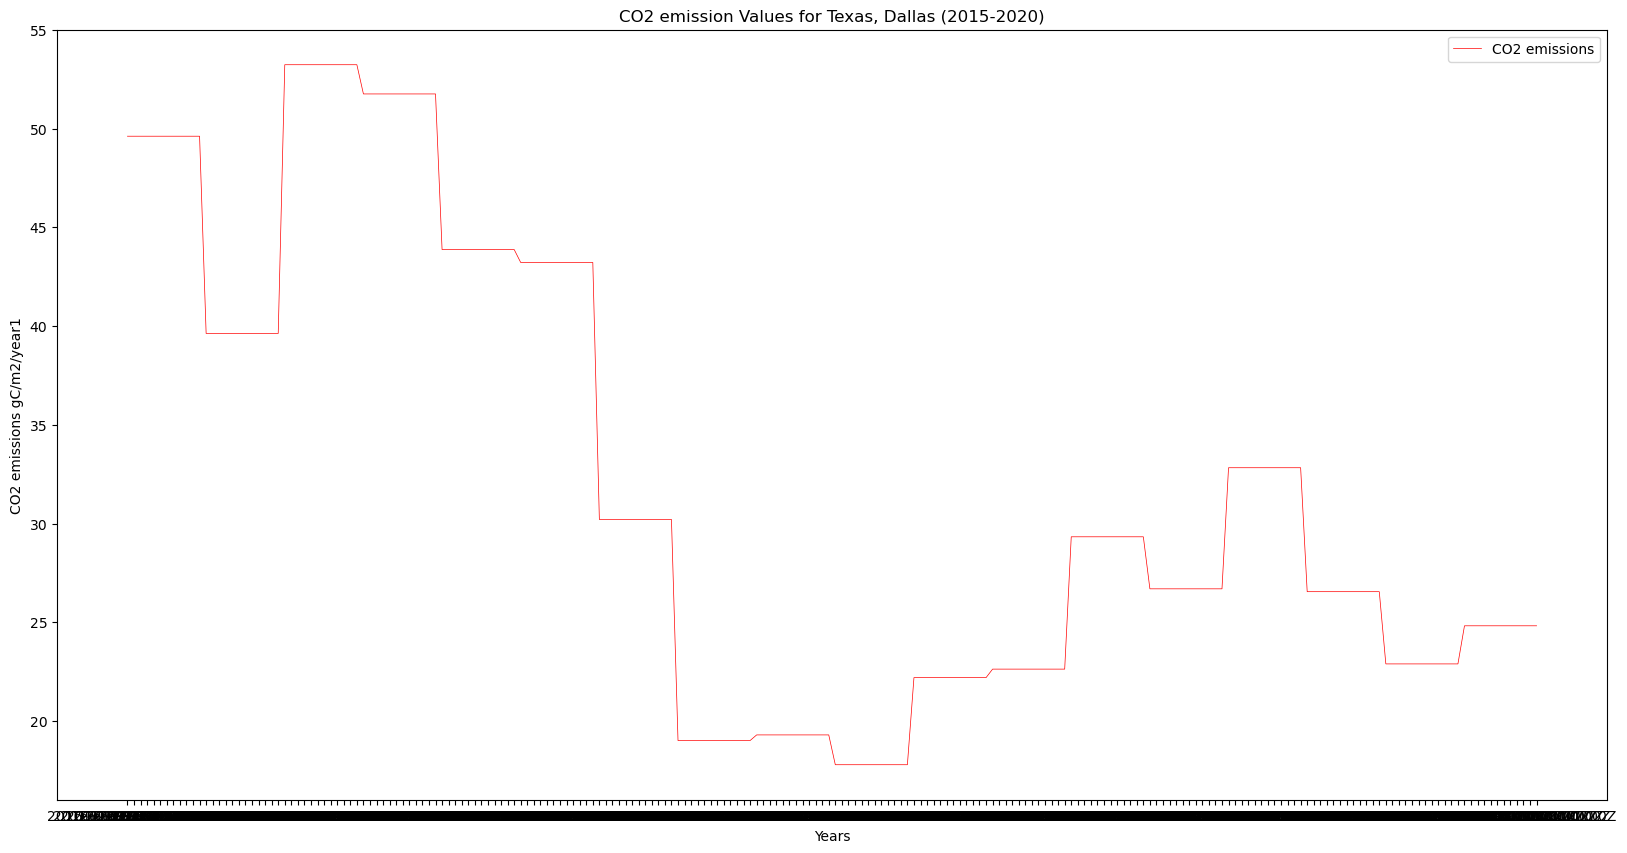

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))


plt.plot(
    df["datetime"],
    df["max"],
    color="red",
    linestyle="-",
    linewidth=0.5,
    label="CO2 emissions",
)

plt.legend()
plt.xlabel("Years")
plt.ylabel("CO2 emissions gC/m2/year1")
plt.title("CO2 emission Values for Texas, Dallas (2015-2020)")

In [26]:
print(items[2]["properties"]["start_datetime"])

2016-10-01T00:00:00Z


In [27]:
co2_flux_3 = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[2]['collection']}&item={items[2]['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}",
).json()
co2_flux_3

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://2qncpyg24c.execute-api.us-west-2.amazonaws.com/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=tm54dvar-ch4flux-monthgrid-v1&item=tm54dvar-ch4flux-monthgrid-v1-201610&assets=fossil&color_formula=gamma+r+1.05&colormap_name=magma&rescale=0.0%2C202.8189294183266'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [28]:
# Use bbox initial zoom and map
# Set up a map located w/in event bounds
import folium

aoi_map_bbox = Map(
    tiles="OpenStreetMap",
    location=[
        30,-100
    ],
    zoom_start=6.8,
)

map_layer = TileLayer(
    tiles=co2_flux_3["tiles"][0],
    attr="GHG", opacity = 0.7
)

map_layer.add_to(aoi_map_bbox)

aoi_map_bbox

## Summary

In this notebook we have successfully explored, analyzed, and visualized the STAC collection for CEOS National Top-Down CO₂ Budgets.